/var/folders/q9/0487pnyj0qv0w1ky3fjzljb80000gn/T/ipykernel_18652/1484346751.py:17: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  file1 = pd.read_csv(csv1)


Optimal value of k if we care most about accuracy: 12
Lowest mean accuracy for any value k: 0.9767
Optimal value of k if we care most about overall precision: 18
Optimal value of k if we care most about overall recall: 5
F1 score for banks that failed: 0.2699
Number of banks predicted to NOT fail and did not: 5814
The Southern Community Bank of Fayetteville, Georgia was predicted to have failed.
And Southern Community Bank of Fayetteville, Georgia DID fail.


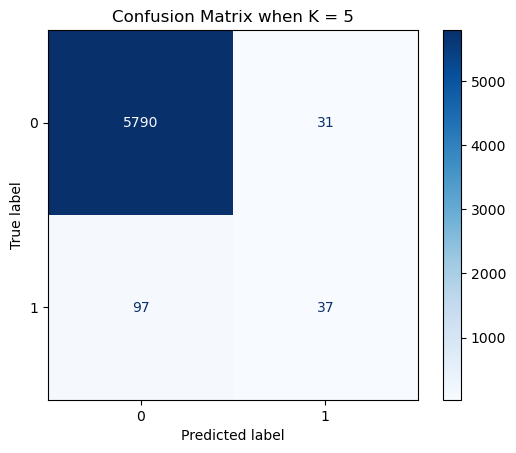

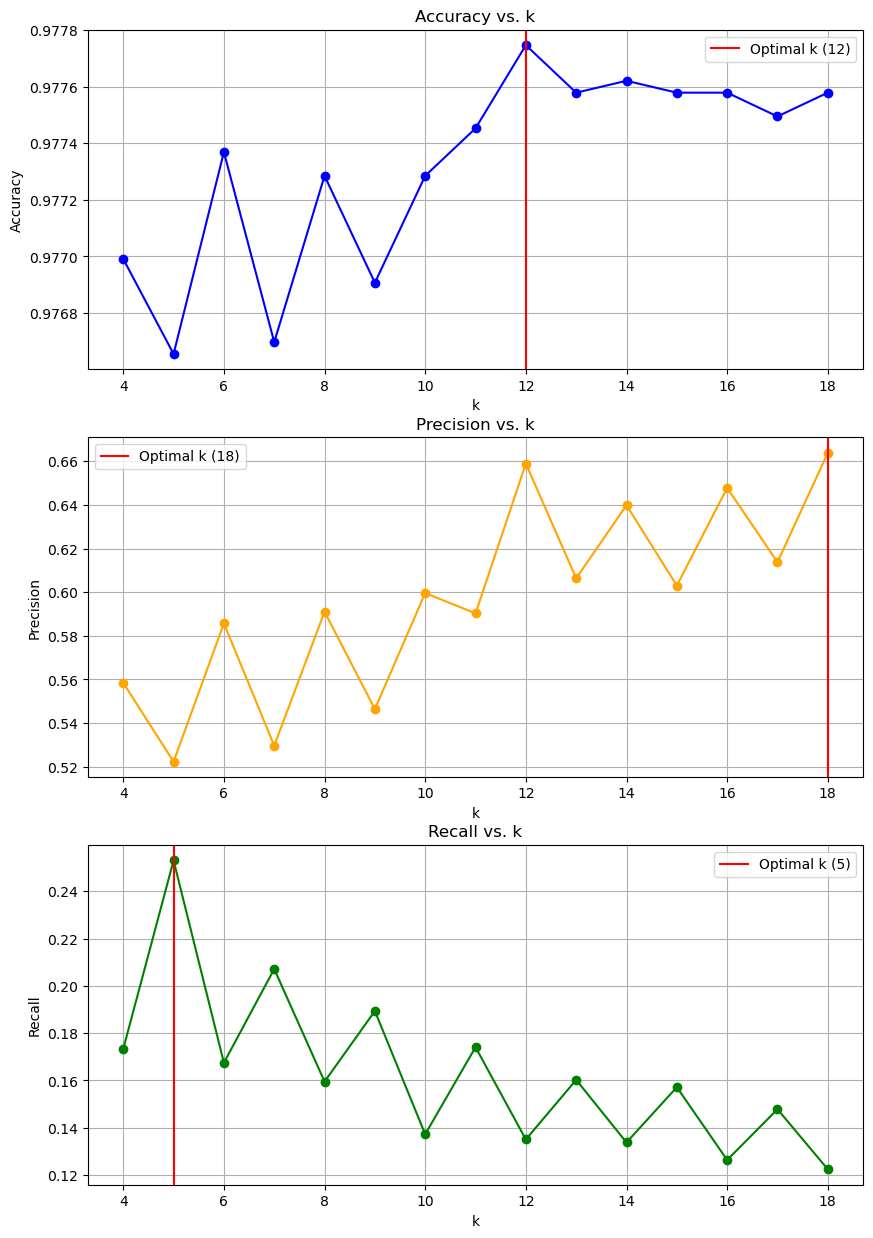

In [28]:
# Code WITH def functions

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

def load_and_merge(csv1, csv2, col1, col2):
    '''
    Function: load_and_merge
    Parameters: two CSV files, two columns
    Returns: merged DataFrame with 'failure' column
    '''
    file1 = pd.read_csv(csv1)
    file2 = pd.read_csv(csv2, encoding = 'cp1252')

    merged_df = pd.merge(file1, file2, left_on = col1, right_on = col2, how = 'left')
    merged_df['failure'] = merged_df[col1].isin(file2[col2]).astype(int)

    return merged_df

def preprocess_data(df, features):
    '''
    Function: preprocess_data 
    Parameters: DataFrame with a list of feature column names
    Returns: processed DataFrame with features normalized using Min-Max scaling
    '''
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    df = df.dropna(subset = features)
    return df

def split_data(df, features, target):
    '''
    Function: split_data
    Parameters: DataFrame, a list of feature column names, and target variable column name
    Returns: train-test split of features and target variable
    '''
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state = 0)
    return X_train, X_test, y_train, y_test

def cross_val(knn, X, y, kfold):
    '''
    Function: cross_val 
    Parameters: K-Nearest Neighbors classifier, X feautres, y target variable, KFold object for cross-validation
    Returns: mean scores for accuracy, precision, and recall
    '''
    accuracy = cross_val_score(knn, X, y, cv = kfold, scoring = 'accuracy').mean()
    precision = cross_val_score(knn, X, y, cv = kfold, scoring = 'precision').mean()
    recall = cross_val_score(knn, X, y, cv = kfold, scoring = 'recall').mean()
    return accuracy, precision, recall

def find_optimal_k(k_range, X, y, kfold):
    '''
    Function: find_optimal_k
    Parameters: list of k values to try, X features, y target variable, KFold object for cross-validation
    Returns: k_accuracy, k_precision, k_recall, lowest_accuracy, results_df
    '''
    results = {'k': [], 'accuracy': [], 'precision': [], 'recall': []}
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k)
        accuracy, precision, recall = cross_val(knn, X, y, kfold)

        results['k'].append(k)
        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)

    results_df = pd.DataFrame(results)
    k_accuracy = results_df['k'][results_df['accuracy'].idxmax()]
    k_precision = results_df['k'][results_df['precision'].idxmax()]
    k_recall = results_df['k'][results_df['recall'].idxmax()]
    lowest_accuracy = results_df['accuracy'].min()

    return k_accuracy, k_precision, k_recall, lowest_accuracy, results_df

def evaluate_knn(X_train, X_test, y_train, y_test, k):
    '''
    Function: evaluate_knn Train a KNN classifier, make predictions, and calculate F1 score
    Parameters: train-test split of features and target variable, number of neighbors for KNN
    Returns: F1 score, true negative count, confusion matrix
    '''
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    f1_failed = f1_score(y_test, y_pred)
    matrix_accuracy = confusion_matrix(y_test, y_pred)
    tn_count = matrix_accuracy[0, 0]

    return f1_failed, tn_count, matrix_accuracy

def pred_bank(state, city, bank_name, df, features, X_train, y_train, k_accuracy):
    '''
    Function: pred_bank
    Parameters: a state, city, bank name, the DataFrame, feature names, training data with labels, optimal k-value
    Returns: a prediction for whether a given bank failed and the actual outcome 
    '''
    bank = df.loc[(df['STNAME'] == state) & (df['CITY'] == city) & (df['Bank Name'] == bank_name)]
    true_fail = bank['failure'].tolist()[0]
    pred_test = bank[features]

    knn_pred = KNeighborsClassifier(n_neighbors = k_accuracy)
    knn_pred.fit(X_train, y_train)

    bank_pred = knn_pred.predict(pred_test)
    bank_pred_int = bank_pred.tolist()[0]

    if bank_pred_int == 1:
        print(f'The {bank_name} of {city}, {state} was predicted to have failed.')
    else:
        print(f'The {bank_name} of {city}, {state} was predicted to have not failed.')

    if true_fail == 1:
        print(f'And {bank_name} of {city}, {state} DID fail.')
    else:
        print(f'And {bank_name} of {city}, {state} DID NOT fail.')

def plot_conf_matrix(X_train, X_test, y_train, y_test, k, title):
    '''
    Function: plot_conf_matrix
    Parameters: a title for the plot
    Returns: a ploted confusion matrix with optimal k for recall
    '''
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    matrix_recall = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(matrix_recall)
    disp.plot(cmap = plt.cm.Blues, values_format = 'd')
    disp.ax_.set_title(title)
    
    plt.show()

def plot_vs_k(results_df, k_types = ['accuracy', 'precision', 'recall'], colors = ['blue', 'orange', 'green']):
    '''
    Function: plot_vs_k 
    Parameters: a DataFrame with k values and results, list of k types ('accuracy', 'precision', 'recall') to plot,
    and a list of colors for each metric
    '''
    fig, axes = plt.subplots(len(k_types), 1, figsize = (10, 15))

    for ax, k_type, color in zip(axes, k_types, colors):
        ax.plot(results_df['k'], results_df[k_type], marker = 'o', color = color)
        ax.set_title(f'{k_type.capitalize()} vs. k')
        ax.set_xlabel('k')
        ax.set_ylabel(k_type.capitalize())

        optimal_k = results_df['k'][results_df[k_type].idxmax()]
        ax.axvline(optimal_k, color = 'red', linestyle = '-', label = f'Optimal k ({optimal_k})')
        ax.legend()
        ax.grid(True)

    plt.show()

def main():
    # Load and merge data
    df = load_and_merge('institutions.csv', 'banklist.csv', 'CERT', 'Cert ')

    # Features
    features = ['ASSET', 'DEP', 'DEPDOM', 'NETINC', 'OFFDOM', 'ROA', 'ROAPTX', 'ROE']

    # Preprocess data
    df = preprocess_data(df, features)

    # Target variable (y) and features (X)
    y = df['failure']
    X = df[features]

    # Split data
    X_train, X_test, y_train, y_test = split_data(df, features, 'failure')

    # Variables and result storage
    k_range = list(range(4, 19))
    kfold = KFold(n_splits = 4, random_state = 0, shuffle = True)

    # Find optimal k values
    k_accuracy, k_precision, k_recall, lowest_accuracy, results_df = find_optimal_k(k_range, X, y, kfold)

    # Print results for Q1-Q4
    print(f'Optimal value of k if we care most about accuracy: {k_accuracy}')
    print(f'Lowest mean accuracy for any value k: {lowest_accuracy:.4f}')
    print(f'Optimal value of k if we care most about overall precision: {k_precision}')
    print(f'Optimal value of k if we care most about overall recall: {k_recall}')

    # Train and evaluate KNN with optimal k for accuracy
    f1_failed, tn_count, matrix_accuracy = evaluate_knn(X_train, X_test, y_train, y_test, k_accuracy)
    
    # Print F1 score, TN count, and bank prediction for Q5a-c
    print(f'F1 score for banks that failed: {f1_failed:.4f}')
    print(f'Number of banks predicted to NOT fail and did not: {tn_count}')
    pred_bank('Georgia', 'Fayetteville', 'Southern Community Bank', df, features, X_train, y_train, k_accuracy)

    # Plot 1 - confusion matrix for recall - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    plot_conf_matrix(X_train, X_test, y_train, y_test, k_recall, 'Confusion Matrix when K = 5')

    # Plot 2 - accuracy, precision, recall against k - https://docs.python.org/3.3/library/functions.html#zip
    plot_vs_k(results_df, k_types = ['accuracy', 'precision', 'recall'], colors = ['blue', 'orange', 'green'])

if __name__ == "__main__":
    main()

/var/folders/q9/0487pnyj0qv0w1ky3fjzljb80000gn/T/ipykernel_18652/3725405990.py:4: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  institutions = pd.read_csv('institutions.csv')


Optimal value of k if we care most about accuracy: 12
Lowest mean accuracy for any value k: 0.9767
Optimal value of k if we care most about overall precision: 18
Optimal value of k if we care most about overall  recall: 5
F1 score for banks that failed: 0.2699
Number of banks predicted to NOT fail and did not: 5814
The Southern Community Bank of Fayetteville, Georgia was predicted to have failed.
And the Southern Community Bank of Fayetteville, Georgia DID fail.


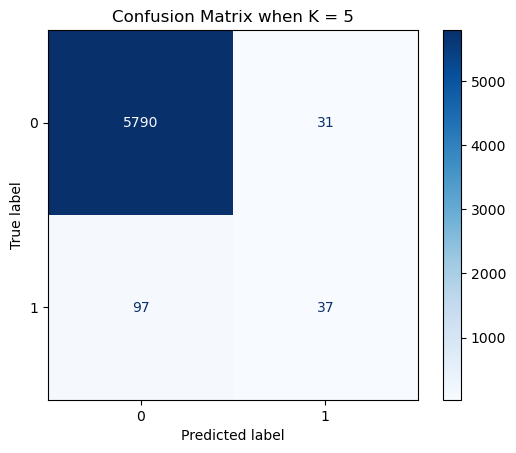

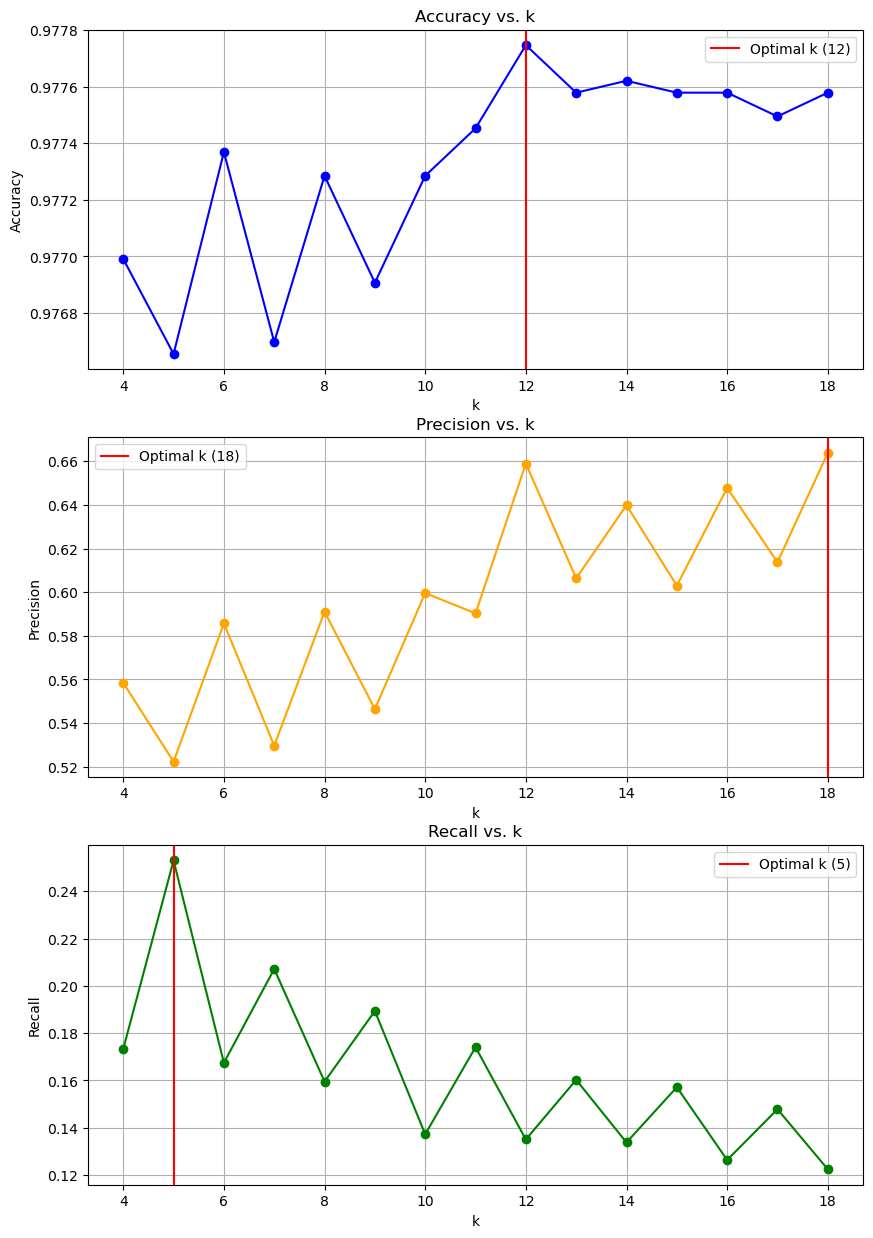

In [29]:
# Code WITHOUT def functions

# Import data
institutions = pd.read_csv('institutions.csv')
banklist = pd.read_csv('banklist.csv', encoding = 'cp1252')

# Merge the dfs on 'cert'
df = pd.merge(institutions, banklist, left_on = 'CERT', right_on = 'Cert ', how = 'left')

# Create a column 'failure' indicating whether the bank has failed or not (0 or 1)
failed = institutions['CERT'].isin(banklist['Cert '])
failed = failed.replace({True: 1, False: 0})
df['failure'] = failed

# Isolate features and normalize them using min-max normalization
features = ['ASSET', 'DEP', 'DEPDOM', 'NETINC', 'OFFDOM', 'ROA', 'ROAPTX', 'ROE']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df = df.dropna(subset = features)

# Target variable (y) and features (X)
y = df['failure']
X = df[features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# Variables and result storage
k_range = list(range(4, 19))
results = {'k': [], 'accuracy': [], 'precision': [], 'recall': []}

# Iterate over different values of k ranging from 4 to 18
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    kfold = KFold(n_splits = 4, random_state = 0, shuffle = True)

    # Cross-validation using training data
    accuracy_results = cross_val_score(knn, X, y, cv = kfold, scoring = 'accuracy')
    precision_results = cross_val_score(knn, X, y, cv = kfold, scoring = 'precision')
    recall_results = cross_val_score(knn, X, y, cv = kfold, scoring = 'recall')

    # Store mean scores for each k
    results['k'].append(k)
    results['accuracy'].append(accuracy_results.mean())
    results['precision'].append(precision_results.mean())
    results['recall'].append(recall_results.mean())

# Create a results df 
results_df = pd.DataFrame(results)

# Find the k values for accuracy, precision, recall, and lowest accuracy
k_accuracy = results_df['k'][results_df['accuracy'].idxmax()]
k_precision = results_df['k'][results_df['precision'].idxmax()]
k_recall = results_df['k'][results_df['recall'].idxmax()]
lowest_accuracy = results_df['accuracy'].min()

# Q1-4
print(f'Optimal value of k if we care most about accuracy: {k_accuracy}')
print(f'Lowest mean accuracy for any value k: {lowest_accuracy:.4f}')
print(f'Optimal value of k if we care most about overall precision: {k_precision}')
print(f'Optimal value of k if we care most about overall  recall: {k_recall}')

# Q5a
knn_accuracy = KNeighborsClassifier(n_neighbors = k_accuracy)
knn_accuracy.fit(X_train, y_train)
y_pred_accuracy = knn_accuracy.predict(X_test)

# Calculate the F1 score for banks that failed
f1_failed = f1_score(y_test, y_pred_accuracy)

print(f'F1 score for banks that failed: {f1_failed:.4f}')

# Q5b
matrix_accuracy = confusion_matrix(y_test, y_pred_accuracy)

# True Negatives (TN)
tn_count = matrix_accuracy[0, 0]

print(f'Number of banks predicted to NOT fail and did not: {tn_count}')

# Q5c
bank = df.loc[(df['STNAME'] == 'Georgia') & (df['CITY'] == 'Fayetteville') & (df['Bank Name'] == 'Southern Community Bank')]
true_fail = bank['failure'].tolist()[0]
pred_test = bank[features]

knn_pred= KNeighborsClassifier(n_neighbors = k_accuracy)
knn_pred.fit(X_train, y_train)

bank_pred = knn_pred.predict(pred_test)
bank_pred_int = scb_pred.tolist()[0]

if bank_pred_int == 1:
    print('The Southern Community Bank of Fayetteville, Georgia was predicted to have failed.')
else:
    print('The Southern Community Bank of Fayetteville, Georgia was predicted to have not failed.')

if true_fail == 1:
    print('And the Southern Community Bank of Fayetteville, Georgia DID fail.')
else:
    print('And the Southern Community Bank of Fayetteville, Georgia DID NOT fail.')

# Plot 1 - https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
knn_recall = KNeighborsClassifier(n_neighbors=k_recall)
knn_recall.fit(X_train, y_train)
y_pred_recall = knn_recall.predict(X_test)

matrix_recall = confusion_matrix(y_test, y_pred_recall)

disp = ConfusionMatrixDisplay(matrix_recall)
disp.plot(cmap = plt.cm.Blues, values_format = 'd')
disp.ax_.set_title(f'Confusion Matrix when K = {k_recall}')

plt.show()

# Plot 2 - https://docs.python.org/3.3/library/functions.html#zip
k_type = ['accuracy', 'precision', 'recall']
color = ['blue', 'orange', 'green']

fig, axes = plt.subplots(len(k_type), 1, figsize = (10, 15))

for ax, k_type, color in zip(axes, k_type, color):
    ax.plot(results_df['k'], results_df[k_type], marker = 'o', color = color)
    ax.set_title(f'{k_type.capitalize()} vs. k')
    ax.set_xlabel('k')
    ax.set_ylabel(k_type.capitalize())
    
    optimal_k = results_df['k'][results_df[k_type].idxmax()]
    ax.axvline(optimal_k, color = 'red', linestyle = '-', label = f'Optimal k ({optimal_k})')
    ax.legend()
    ax.grid(True)

plt.show()